In [235]:
import os
import sys
from importlib import reload
sys.path.append('../src')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

In [2]:
import transformers

In [3]:
import torch.utils.data as D

In [4]:
import dataset
import transforms

[nltk_data] Downloading package punkt to
[nltk_data]     /gpfs/hpc/home/papkov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Dataset

In [238]:
reload(dataset)
valid = dataset.TokenizerDataset('../input/validation.csv')

In [239]:
%%time
item = valid[35]

CPU times: user 16.6 ms, sys: 2.08 ms, total: 18.7 ms
Wall time: 41.3 ms


#### Pre-tokenized version

In [183]:
reload(dataset)
valid = dataset.Dataset('../input/validation.npz')

## Sampling

We will create weighted random sampler that will produce random samples with replacement for each epoch with approximately equal amount of positiva and negative samples

In [184]:
sampler = valid.weighted_sampler()

In [205]:
# rerun this cell to ensure that values will be different for each epoch
sampled = [i for i in sampler]
np.unique(valid.y[sampled], return_counts=True), len(sampled)

((array([0, 1], dtype=uint8), array([1228, 1232])), 2460)

## Text transforms

In [271]:
reload(transforms)

<module 'transforms' from '../src/transforms.py'>

In [256]:
len(sent.split())

204

In [258]:
np.max(valid.dataset[valid.text_column].apply(lambda x: len(x.split())))

211

In [263]:
sent = valid.dataset[valid.text_column][350]
sent

' Texto de titular e van a comer la polla el ijo puta del feran maxado k va escribiendo cosas x internet i del imbecil del xavi!!! k sa comido mismocos! !! subnormales!!!'

In [272]:
truncate_sent = transforms.Truncate(p=1)
truncate_sent(sent)

'Texto de titular e van a comer la polla el ijo puta del feran maxado k va escribiendo cosas x internet i del imbecil del xavi!!! k sa comido mismocos! !! subnormales!!!'

In [242]:
shuffle_sent = transforms.ShuffleSentences(p=1)
shuffle_sent(sent)

'Tu sei beato Akiva, avrai una parte nel Mondo Avvenire.»[4]  Una frase simile non e  appropriata in un enciclopedia. Che una simile panzana sia stata raccontata e  fuori discussione, che si racconti ora, ridicolo.  Si racconta che in quel momento una voce dal Cielo proclamò: «Tu sei beato Akiva, il tuo respiro si è spento con  Echad .'

In [71]:
%timeit _ = shuffle_sent(sent)

81.3 µs ± 663 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [73]:
shuffle_word = transforms.SwapWords(p=1, swap_p=0.1)
shuffle_word(sent)

'Si racconta che in quel momento una voce dal Cielo proclamò: «Tu beato sei Akiva, il tuo respiro si è spento con Echad . Tu sei beato Akiva, avrai una parte nel Avvenire.»[4] Mondo frase Una simile non e appropriata in un enciclopedia. Che una simile sia panzana stata raccontata fuori discussione, e che si ora, ridicolo. racconti'

In [74]:
%timeit _ = shuffle_word(sent)

152 µs ± 42.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [77]:
drop_word = transforms.DropWords(p=1, drop_p=0.1)
drop_word(sent)

'Si racconta che in quel momento voce dal Cielo proclamò: «Tu sei Akiva, il tuo respiro si è spento con Echad . Tu sei beato avrai una parte nel Mondo Avvenire.»[4] Una frase simile non appropriata in un enciclopedia. Che una simile panzana sia stata raccontata e fuori discussione, che si racconti ora, ridicolo.'

In [78]:
%timeit _ = drop_word(sent)

157 µs ± 45 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [80]:
all_transforms = transforms.Compose([
    transforms.ShuffleSentences(p=0.5),
    transforms.SwapWords(swap_p=0.1),
    transforms.DropWords(drop_p=0.1),
])
all_transforms(sent)

'Tu sei beato Akiva, avrai una parte nel Mondo Avvenire.»[4]  Una frase simile non e  appropriata in un enciclopedia.  Si racconta che in quel momento una voce dal Cielo proclamò: «Tu sei beato Akiva, il tuo respiro si è spento con  Echad . Che una simile panzana sia stata raccontata e  fuori discussione, che si racconti ora, ridicolo.'

In [81]:
%timeit _ = all_transforms(sent)

200 µs ± 49.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Token transforms 

In [128]:
reload(transforms)

<module 'transforms' from '../src/transforms.py'>

In [129]:
print(valid.df[valid.text_column][500])
sent = valid[500][0].numpy()
sent[:50]

 Si racconta che in quel momento una voce dal Cielo proclamò: «Tu sei beato Akiva, il tuo respiro si è spento con  Echad . Tu sei beato Akiva, avrai una parte nel Mondo Avvenire.»[4]  Una frase simile non e  appropriata in un enciclopedia. Che una simile panzana sia stata raccontata e  fuori discussione, che si racconti ora, ridicolo.


array([     0,    602,  54963,    290,     23,  19488,   3594,    220,
        26845,   1640,   2079,   8242,    502,  60397,   2516,     12,
           94,  15665,   7583,    186,   2832,  36851,    330,      4,
          211,   3860, 225565,     78,    565,  66933,     31,    158,
        74242,   8408,      6,      5,   1371,   7583,    186,   2832,
        36851,    330,      4,    185,   8287,    220,   1235,   1718,
       168054,   4908])

In [130]:
shuffle_sent = transforms.TokenShuffleSentences(p=1)
valid.tokenizer.decode(shuffle_sent(sent)[shuffle_sent.mask(sent)])

'Si racconta che in quel momento una voce dal Cielo proclamò: «Tu sei beato Akiva, il tuo respiro si è spento con Echad. Che una simile panzana sia stata raccontata e fuori discussione, che si racconti ora, ridicolo. Tu sei beato Akiva, avrai una parte nel Mondo Avvenire.»[] Una frase simile non e appropriata in un enciclopedia.'

In [123]:
%timeit _ = shuffle_sent(sent)

29.5 µs ± 4.63 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [131]:
shuffle_word = transforms.TokenSwapWords(p=1, swap_p=0.1)
valid.tokenizer.decode(shuffle_word(sent)[shuffle_word.mask(sent)])

'Si racconta che in quel momento una voce dalelo pro Ciclamò: «Tu sei beatova Aki, il respiro tuo si è spento con Echad. Tu sei beato Akiva, avrai una nel parte Mondo Avvenire.[»] Una frase simile non e appropriata in en unciclopedia. Che una simile panzana sia stata raccontata e fuorie discussion, che si racconti ora, ridicolo.'

In [132]:
%timeit _ = shuffle_word(sent)

1.4 ms ± 319 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [133]:
drop_word = transforms.TokenDropWords(p=1, drop_p=0.1)
valid.tokenizer.decode(drop_word(sent)[drop_word.mask(sent)])

'Si racconta in quel momento voce dal Ci proclamò: «Tu seiato Akiva, il tuo respiro si è spento Echad. Tu seiato Akiva, avrai una parte nel Mondo Avvenire.»[ Una frase simile non e appropriata in unciclopedia. Che una simile panzana sia stata raccontata e fuori discussione, che si racconti ora,olo.</s><pad><pad><pad><pad><pad><pad><pad><pad>'

In [134]:
%timeit _ = drop_word(sent)

1.38 ms ± 351 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [137]:
all_transforms = transforms.Compose([
    transforms.TokenShuffleSentences(p=0.5),
    transforms.TokenSwapWords(swap_p=0.1),
    transforms.TokenDropWords(drop_p=0.1),
])
valid.tokenizer.decode(all_transforms(sent)[drop_word.mask(sent)])

'Tu sei beato Akiva, avrai una parte nel Mondo Avvenire. Si racconta in quel momento una voce dal Cielo proclamò: «Tu beato Akiva, il tuo respiro si è spento con Echad. Che una simile panzana sia stata raccontata e fuorie, che si racconti ora, ridicolo.»[] Una frase simile non e appropriata in enciclopedia.</s><pad><pad><pad>'

In [138]:
%timeit _ = all_transforms(sent)

1.32 ms ± 380 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Multilingual dataset 

In [79]:
tr = pd.read_csv('../input/multilingual-train-ludovick/jigsaw-toxic-comment-train_tr_clean.csv')
# ru = pd.read_csv('../input/multilingual-train/jigsaw-toxic-comment-train-google-ru-cleaned.csv')

In [10]:
ru = pd.read_csv('../input/multilingual-train/jigsaw-toxic-comment-train-google-ru.csv')

In [80]:
tr.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
223536,fff8f64043129fa2,": Jerome, görüyorum ki, bununla hiç uğraşmadın...",0,0,0,0,0,0
223537,fff9d70fe0722906,== Şanslı piç == http://wikimediafoundation.o...,0,0,0,0,0,0
223538,fffa8a11c4378854,== hepinize utanç !!! == Geylerden bahsetmek...,0,0,0,0,0,0
223539,fffac2a094c8e0e2,"MEL GIBSON, SHITTY FİLMLERİ YAPAN NAZI HATTI. ...",1,0,1,0,1,0
223540,fffb5451268fb5ba,""" == Unicorn inine keşif == Sözde, Kuzey K...",0,0,0,0,0,0


In [11]:
ru.tail()

,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
223544,223544,fff8f521a7dbcd47,"закрыл мексиканскую границу, не выглядел плохо",0,0,0,0,0,0
223545,223545,fffac2a094c8e0e2,"Мэл Гибсон - нацистская сучка, которая делает ...",1,0,0,0,0,0
223546,223546,fff8f64043129fa2,": Джером, я вижу, ты никогда не удосужился к э...",0,0,0,0,0,0
223547,223547,fffa8a11c4378854,== позор вам всем !!! ==\n\n Вы хотите говорит...,0,0,1,0,1,0
223548,223548,fff718ffe5f05559,Я только что обнаружил еще один список: список...,0,0,0,0,0,0


In [16]:
from functools import reduce

In [42]:
np.random.choice(langs)

'it'

In [40]:
# read multilingual
langs = ['es', 'tr', 'ru', 'fr', 'it', 'pt']
path = '../input/multilingual-train/jigsaw-toxic-comment-train-google-{}-cleaned.csv'
multilingual_df = [pd.read_csv(path.format(lang), index_col=0)[['id', 'comment_text', 'toxic']] for lang in langs]
# add english
multilingual_df.append(pd.read_csv('../input/jigsaw-toxic-comment-train.csv')[['id', 'comment_text', 'toxic']])
langs.append('en')
# merge
multilingual_df = reduce(lambda x, y: pd.merge(x, y, on='id'), multilingual_df)
# clean
multilingual_df = multilingual_df.drop(['toxic_x', 'toxic_y'], 1).tail()
multilingual_df.columns = ['id'] + langs + ['toxic']

In [41]:
multilingual_df.tail()

,id,es,tr,ru,fr,it,pt,en,toxic
223126,fff83b80284d8440,:: ¿Consenso para arruinar Wikipedia? Creo que...,:: Wikipedia'yı mahvetmek için fikir birliği m...,:: Консенсус для разрушения Википедии? Я думаю...,:: Consensus pour ruiner Wikipedia? Je pense q...,:: Consenso per aver rovinato Wikipedia? Penso...,:: Consenso para arruinar a Wikipedia? Eu acho...,::Consensus for ruining Wikipedia? I think tha...,0
223127,fff718ffe5f05559,Acabo de descubrir otra lista: la lista de com...,Başka bir liste daha keşfettim: Adlarına göre ...,Я только что обнаружил еще один список: список...,Je viens de découvrir encore une autre liste: ...,Ho appena scoperto un altro elenco: Elenco dei...,Acabei de descobrir mais uma lista: Lista de c...,I've just discovered yet another list: List of...,0
223128,fff23c3e174e895e,"""\n He estado leyendo esta página de discusión...","""\n Bu konuşma sayfasını okudum ve bazı insanl...","""\n Я читал эту страницу обсуждения, и я был п...","""\n 'ai lu cette page de discussion et j'ai ét...","""\n Ho letto questa pagina di discussione e so...","""\n li esta página de discussão e fiquei impre...",""" \n 've been reading this talk page and I was...",0
223129,fffa8a11c4378854,== ¡Qué vergüenza para todos! ==\n\n Quieres h...,== hepinize utanç !!! ==\n\n Geylerden bahsetm...,== позор вам всем !!! ==\n\n Вы хотите говорит...,== honte à vous tous !!! ==\n\n Vous voulez pa...,== vergogna per tutti !!! ==\n\n Vuoi parlare ...,== vergonha para todos vocês !!! ==\n\n Você q...,==shame on you all!!!== \n\n You want to speak...,0
223130,ffebe90c8d5acaba,"""\n\n == IRÁN ==\n Así es, Irán. Fue nuestro d...","""\n\n == İRAN ==\n Bu doğru, İran. Bu bizim dr...","""\n\n == ИРАН ==\n Это верно, Иран. Это был на...","""\n\n == L'IRAN ==\n C'est vrai, l'Iran. C'éta...","""\n\n == IRAN ==\n Proprio così, l'Iran. Era i...","""\n\n == IRAN ==\n Isso mesmo, Irã. Foi o noss...",""" \n\n == IRAN == \n That’s right, Iran. It wa...",1


In [88]:
reload(dataset)

<module 'dataset' from '../src/dataset.py'>

In [89]:
multilingual_df = dataset.read_multilingual_dataset()

In [97]:
multilingual_df.head(20)

,id,es,tr,ru,fr,it,pt,en,toxic
0,0000997932d777bf,Explicación ¿Por qué se revertieron las edicio...,açıklama Hardcore Metallica Fan kullanıcı adım...,"объяснение Почему изменения, сделанные под мои...",Explication Pourquoi les modifications apporté...,Spiegazione Perché le modifiche apportate con ...,Explicação Por que as edições feitas com o meu...,Explanation Why the edits made under my userna...,0
1,000103f0d9cfb60f,D'aww! Él coincide con este color de fondo con...,D'aww! Görünüşe göre sıkışmış olduğum arka pla...,"D'Оо! Он соответствует этому цвету фона, с кот...",D'aww! Il correspond à cette couleur de fond a...,D'Aww! Si abbina a questo colore di sfondo con...,D'aww! Ele combina com a cor de fundo com a qu...,D'aww! He matches this background colour I'm s...,0
2,000113f07ec002fd,"Hola hombre, realmente no estoy tratando de ed...","Hey adamım, gerçekten savaşı düzenlemeye çalış...","Эй, чувак, я действительно не пытаюсь редактир...","Hé mec, je n'essaye vraiment pas de modifier l...","Ehi amico, non sto davvero cercando di modific...","Ei cara, eu realmente não estou tentando edita...","Hey man, I'm really not trying to edit war. It...",0
3,0001b41b1c6bb37e,""" Más No puedo hacer ninguna sugerencia real s...",""" Daha İyileştirme konusunda gerçek bir önerid...",""" Больше Я не могу вносить какие-либо реальные...",""" Plus Je ne peux pas faire de véritables sugg...",""" Di Più Non posso dare alcun vero suggeriment...",""" Mais Não posso fazer nenhuma sugestão real d...",""" More I can't make any real suggestions on im...",0
4,0001d958c54c6e35,"Usted señor, es mi héroe. ¿Alguna posibilidad ...","Sen, efendim, benim kahramanımsın. Hangi sayfa...","Вы, сэр, мой герой. Есть ли шанс, что вы помни...","Vous, monsieur, êtes mon héros. Vous souvenez-...","Signore, sei il mio eroe. Qualche possibilità ...","Você senhor, é meu heroi. Alguma chance de voc...","You, sir, are my hero. Any chance you remember...",0
5,00025465d4725e87,""" Felicitaciones de mi parte también, usa bie...",""" Benden de tebrikler, araçları iyi kullan. ·...",""" Поздравляю и меня, хорошо использую инструм...",""" Félicitations de ma part également, utilise...",""" Complimenti anche da parte mia, usa bene gl...",""" Parabéns de mim também, use bem as ferramen...",""" Congratulations from me as well, use the to...",0
6,0002bcb3da6cb337,PELUCHE ANTES DE PISAR ALREDEDOR DE MI TRABAJO,KADIN ÇALIŞMAYA ÇALIŞMADAN ÖNCE COCKSUCKER,"Козел, прежде чем вы мочитесь вокруг моей работы",COCKSUCKER AVANT DE PISSER AUTOUR DE MON TRAVAIL,COCKSUCKER PRIMA DI Pisciare SUL MIO LAVORO,COCKSUCKER ANTES DE Mijar no Meu Trabalho,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,00031b1e95af7921,Su vandalismo al artículo de Matt Shirvington ...,Matt Shirvington makalesine vandalizminiz geri...,Ваш вандализм в отношении статьи Мэтта Ширвинг...,Votre vandalisme envers l'article de Matt Shir...,Il tuo vandalismo sull'articolo di Matt Shirvi...,Seu vandalismo ao artigo de Matt Shirvington f...,Your vandalism to the Matt Shirvington article...,0
8,00037261f536c51d,Lo siento si la palabra 'sin sentido' fue ofen...,'Saçma' kelimesi sizi rahatsız ederse özür dil...,"Извините, если слово «ерунда» было для вас оск...",Désolé si le mot «non-sens» vous a choqué. Quo...,"Scusami se la parola ""sciocchezze"" ti è stata ...","Desculpe se a palavra ""absurdo"" foi ofensiva p...",Sorry if the word 'nonsense' was offensive to ...,0
9,00040093b2687caa,alineación sobre este tema y que son contrario...,DuLithgow'un konularına aykırı olan,выравнивание по этому вопросу и которые против...,alignement sur ce sujet et qui sont contraires...,allineamento su questo argomento e che sono co...,alinhamento sobre este assunto e que são contr...,alignment on this subject and which are contra...,0


In [92]:
len(multilingual_df)

223541

In [67]:
train = dataset.MultilingualTrainTokenizerDataset()

In [93]:
len(train.dataset)

223131

In [96]:
train.dataset.head(20)

,id,es,tr,ru,fr,it,pt,en,toxic
0,000113f07ec002fd,"Hola hombre, realmente no estoy tratando de ed...","Hey adamım, gerçekten savaşı düzenlemeye çalış...","Эй, чувак, я действительно не пытаюсь редактир...","Hé mec, je n'essaye vraiment pas de modifier l...","Ehi amico, non sto davvero cercando di modific...","Ei cara, eu realmente não estou tentando edita...","Hey man, I'm really not trying to edit war. It...",0
1,000b08c464718505,"""\n\n Con respecto a tus ediciones recientes\n...","""\n\n Son düzenlemelerinizle ilgili\n\nDaha fa...","""\n\n Что касается ваших последних правок\n\nЕ...","""\n\n Concernant vos modifications récentes\n\...","""\n\n Per quanto riguarda le modifiche recenti...","""\n\n Em relação às suas edições recentes\n\nM...","""\n\n Regarding your recent edits \n\nOnce aga...",0
2,001325b8b20ea8aa,Alabanza\n\nLeí este artículo hace unos 6 mese...,Övgü\n\nyaklaşık 6 ay önce bu makaleye baktı -...,Хвалить\n\nпосмотрел эту статью около 6 месяце...,Louange\n\nregardé cet article il y a environ ...,Lode\n\nguardato questo articolo circa 6 mesi ...,Elogio\n\nolhou para este artigo há cerca de 6...,Praise \n\nlooked at this article about 6 mont...,0
3,001c557175094f10,"En otras palabras, eres demasiado vago como pa...","Başka bir deyişle, aslında herhangi bir şeyi b...","Другими словами, вы слишком ленивы, чтобы на с...","En d'autres termes, vous êtes trop paresseux p...","In altre parole, sei troppo pigro per segnalar...","Em outras palavras, você é muito preguiçoso pa...","In other words, you're too lazy to actually po...",0
4,00031b1e95af7921,Su vandalismo al artículo de Matt Shirvington ...,Matt Shirvington makalesine vandalizminiz geri...,Ваш вандализм в отношении статьи Мэтта Ширвинг...,Votre vandalisme envers l'article de Matt Shir...,Il tuo vandalismo sull'articolo di Matt Shirvi...,Seu vandalismo ao artigo de Matt Shirvington f...,Your vandalism to the Matt Shirvington article...,0
5,000f35deef84dc4a,No hay necesidad de disculparse. Un artículo d...,Özür dilemeye gerek yok. Farklı kaynaklardan b...,Там нет необходимости извиняться. Статья в Вик...,Il n'y a pas besoin de s'excuser. Un article W...,Non c'è bisogno di scusarsi. Un articolo di Wi...,Não precisa se desculpar. Um artigo da Wikiped...,There's no need to apologize. A Wikipedia arti...,0
6,0001b41b1c6bb37e,"""\nMás\nNo puedo hacer ninguna sugerencia real...","""\nDaha\nİyileştirme konusunda gerçek bir öner...","""\nБольше\nЯ не могу вносить какие-либо реальн...","""\nPlus\nJe ne peux pas faire de véritables su...","""\nDi Più\nNon posso dare alcun vero suggerime...","""\nMais\nNão posso fazer nenhuma sugestão real...","""\nMore\nI can't make any real suggestions on ...",0
7,0011cc71398479c4,¿Cómo puedo publicar antes de que caduque el b...,Bloğun süresi dolmadan nasıl mesaj gönderebili...,Как я могу опубликовать до истечения срока дей...,Comment puis-je publier avant l'expiration du ...,Come posso pubblicare prima della scadenza del...,Como eu poderia postar antes que o bloqueio ex...,How could I post before the block expires? Th...,0
8,00148d055a169b93,"""\n\nEn absoluto, estás haciendo un argumento ...","""\n\nHiç de değil, burada saman adam tartışmas...","""\n\nВовсе нет, вы тут спорите с соломенным че...","""\n\nPas du tout, vous faites un argument d'ho...","""\n\nNiente affatto, stai facendo una discussi...","""\n\nDe maneira alguma, você está argumentando...","""\n\nNot at all, you are making a straw man ar...",0
9,0010833a96e1f886,"""== ¡Una gran estrella para ti! ==\n\n The Re...","""== Sizin için bir barnstar! ==\n\n Gerçek Ha...","""== Барнстар для тебя! ==\n\n Реальная жизнь ...","""== Une barnstar pour vous! ==\n\n La vraie v...","""== Un barnstar per te! ==\n\n La vita reale ...","""== Um barnstar para você! ==\n\n A vida real...","""== A barnstar for you! ==\n\n The Real Life ...",0


In [74]:
print(train.text_column)
train[0]

tr


(tensor([     0,  28240,    332,      4,     87,     25,     39,   6183,    959,
          31577,     47,  27211,   1631,      5,   1650,     25,      7,   1660,
            450,    903,  48948,     83, 178308,  49146,   6496,  29191,   4677,
            136,  56661,     47,    163,   8305,  27211,      7,  64457,    111,
            759,  22120,   9191,      5,   1529,  37202,     47,    517,   1286,
           1672,     70,   9384,   1916,   3501,     70,   8561,   3004,      5,
              2,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,    

In [114]:
train_seq = dataset.TokenizerDataset('../input/jigsaw-toxic-comment-train.csv', max_length=256)

In [140]:
loader_train_seq = D.DataLoader(train_seq, batch_size=8, num_workers=8)

In [116]:
next(iter(loader_train_seq))[1][:,1]

tensor([[1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0]])

In [136]:
train_seq.y.shape

(223549,)

In [141]:
loader_train_seq.dataset.y.shape

(223549,)

In [115]:
train_seq.dataset.shape

(223549, 8)

In [149]:
train_df = dataset.read_multilingual_dataset()

In [99]:
train_df = pd.read_csv('../input/jigsaw-toxic-comment-train.csv')

In [222]:
test_df = pd.read_csv('../input/test.csv')

In [98]:
train_scores = np.load('../output/pred_train_roberta_simple_cls_freeze_4_half_multilingual.npy')

In [100]:
from scipy.special import softmax

In [104]:
train_pred = softmax(train_scores / 1, 1)[:,1]
train_pred[:5]

array([0.05448208, 0.02949633, 0.20030609, 0.02254736, 0.0528799 ],
      dtype=float32)

In [150]:
len(train_df)

223541

In [148]:
len(train_scores)

223541

In [117]:
train_pred > 0.5

array([False, False, False, ...,  True,  True, False])

In [151]:
train_df.toxic

0         0
1         0
2         0
3         0
4         0
         ..
223536    0
223537    0
223538    0
223539    1
223540    0
Name: toxic, Length: 223541, dtype: int64

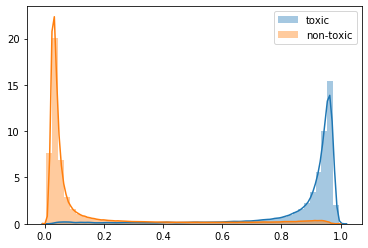

In [157]:
sns.distplot(train_pred[train_df.toxic.astype(bool)], label='toxic')
sns.distplot(train_pred[~train_df.toxic.astype(bool)], label='non-toxic')
plt.legend()
plt.show()

In [159]:
# FN
np.sum(train_df.toxic.astype(bool) & (train_pred < 0.5))

1392

In [160]:
# FP
np.sum(~train_df.toxic.astype(bool) & (train_pred > 0.5))

19790

In [176]:
confusing = (train_df.toxic.astype(bool) & (train_pred < 0.25)) | (~train_df.toxic.astype(bool) & (train_pred > 0.75))
np.sum(confusing)

12178

In [181]:
assured = (train_df.toxic.astype(bool) & (train_pred > 0.97)) | (~train_df.toxic.astype(bool) & (train_pred < 0.03))
np.sum(assured)

54899

In [225]:
to_filter = assured | confusing
np.sum(to_filter)

67077

In [234]:
len(train_df) - np.sum(to_filter)

156464

In [231]:
np.save('../output/filter_confusing_025_assured_097.npy', to_filter)

In [232]:
np.unique(train_df.toxic[to_filter], return_counts=True)

(array([0, 1]), array([64292,  2785]))

In [233]:
np.unique(train_df.toxic, return_counts=True)

(array([0, 1]), array([202157,  21384]))

In [169]:
pd.set_option('display.max_colwidth', -1)

In [171]:
train_df['score'] = train_pred

In [196]:
import re

In [200]:
re.sub('[Ff]\*ck', 'fuck', '@KWW and father F*cker, u still didnt give no source haha:P what a sore f*cking loser haha:P')

'@KWW and father fucker, u still didnt give no source haha:P what a sore fucking loser haha:P'

In [204]:
re.sub(r'[\@\#\$\%\^]{3,}', 'fuck', "s to a @#% funny it is then. I will give you 5 days to delete it or i will access the wikipedia IP adress and i will make u pay. You really @#$%^ up this time, don't u ever do this sh*t again !")

"s to a fuck funny it is then. I will give you 5 days to delete it or i will access the wikipedia IP adress and i will make u pay. You really fuck up this time, don't u ever do this sh*t again !"

In [220]:
re.sub(r' \*\*\*\* ', r' fuck ', 'give a **** on them. I inserted')

'give a fuck on them. I inserted'

In [221]:
train_df[train_df.en.str.find('leet') != -1][['en', 'toxic']]

,en,toxic
107,""" What's up with this? """"If you are a religiously or politically motivated to push this or that issue, please refrain from talking on my page. I am not interested. Otherwise, feel free to talk about relevant edits here or science. Deleet (talk) I would prefer if the following users never post here: Maunus ·ʍaunus·snunɐw WeijiBaikeBianji"""" This guy is a published psychology researcher right? Perhaps he doesn't know you have access to libraries and the best sources. You should point that out more often. It doesn't come across as mind-bendingly condescending. Also I suspect that editor is a racist. See you on the wiki. 121.134.219.36 """,0
1104,"As you kinow it yourself you are not elligible nor credible nor a reliable source of neutrality in this case as you are yourself a mormon and all you do is to support other mormons, without following any wikipedias rules, but your own churchs solidarity. I dont believe that any of you has even the intention of being straightfo9rward with non mormon or to be a little bit honest, but that the alone thing that activate you is your own religious believe and the pedantisme to think that all you may say or do is auto righteous in the name of the church and all the illusions you dream of with open eyes. I dont want a mormon admi I dont want a mmormon admi I dont want a mormon admi to look into this case but an exterm¨n al one with no relations nor conacts what so ever with this church nor its representants or members. If you cant do that, must be because your circle of admi friends is around the church, or because you know very deeply that all you did was deeply unappropriate and wont stand a micro mile in a wiki trail. I am mad, very mad at you, also because you ignore what I have say, so why should I care about your saying and doing if we have to be neutraly equal? Any idea? I want the text who was deleeted from the archive, it is unacceptable that a text is deleeted from archive and from the edit history, just one hour after it was reverted and less than a day after it was written, without any previous warning of any kind about it. This is all about wiki rules and you have broken them all.",0
4880,""" The WP:Airlines is only a suggestion, it is not policy. Guess what outside of your flight sim community the average user of wiki does not care about destinations and my edit improves the article and still allows people interested in destinations to click the """"show"""". WP:AIRLINES is not policy, it is a suggestion. Maybe you should care more about the introduction and history section of articles instead of the destination and fleet size (both of which are to minimal interest to the average public) 76.19.222.40 """,0
8191,""" , you are correct about the """"авиа́ции"""" word but wrong about lyotchik. In russia civil pilots a called """"пило́т"""" (pilót), and military pilots are called """"лё́тчик"""" (lyótchik), it is a military profession not a rank same as pilot not a rank in any military. Word """"солда́т"""" (soldát) means soldier and used same way as in english. Word """"моря́к"""" (moryák) in russian comes from word """"море́"""" (moryé) meaning sea so in general speech it coul be translated as a seaman (even some online translaters do that) or as a sailor, but in military ranks important is the equevalency not the translation, and the equivalent to U.S. rank of seeman would be russian rank of matros, while moryak is general term which could applied to anybody who seves in navy or in a civil fleet. """,0
8945,"The poobotsdam declaration We-the undersigned, representing the hundreds of millions of other vandals and trolls, have conferred and agree that Wikipedia shall be given an opportunity to end this war. The prodigious land, sea and air forces of the undersigned, many times reinforced by their armies and air fleets from the west, are poised to strike the final blows upon Wikipedia. This military power is sustained and inspired by the determination of all the Allie

In [223]:
test_df[test_df.content.str.find('**') != -1][['content']]

,content
70,"Rognutdjûû néon à la c** Joli choix d image, je m étonne tout seul de ne pas avoir fait le lien avec cette poche branchiale, maintenant plus moyen de m enlever cette vision de la chose, sacripant ! Totodu74 (devesar…) Et dire que je pensais benoîtement te faire de la pub sur tes remarquables documents de petites et grosses bébêtes, quelles affres ! De là à ce qu une prude âme de passage sur le bistrot m accuse d attaque par argumentum ad hominem, ad personam, ad verecundiam, ad libitum , et, in fine, habeas corpus delicti et delirium tremens (de quoi perdre son Wicipædia), la messe serait dite (si ce n est ite missa est ). Ceci écrit, . Je ne me serais pas permis ce genre de chose si tu n avais pas prouvé que l humour ne t es pas étranger, bien sûr. Je te souhaite une bonne candidature (très bien partie pour le triomphe, d ailleurs) ; je pense que tu feras un excellent admin pas de fauxcul-isme ici. Amicalement, Warp3 (d)"
251,"El Aborto Consiste Que A Tales Estupidas ,Horrorosas Personas lo hacen .... en mi parecer son una mierda De personas matan a un ser humano un bebe ** Son Weones O Se hacen vallan a comprar condones o pastillas pobres culiaos .ll. vengan a shuparme esta gilas culias...!.... perros que no piensan haser otras weas que puro sexo.... feas culias piensen antes de hacer weas que mataran !..... Mueranseee .............................Piensen las cosas mas de 1000 veces antes de hacerlo, son cosas que despues lamentaran haber hecho solo por que tambien si no se dan cuenta matan una vida y pueden quedar sin poder tener mas hijos mas adelante gilas culias aprendan c;"
436,| bgcolor=#f5f5dc | Rio de Janeiro |20px Rio de Janeiro | Estádio do Maracanã | 50 mil pessoas | bgcolor=#f5f5dc | Salvador |20px Bahia | Arena da Bahia (****) | 50 mil pessoas | bgcolor=#f5f5dc | São Paulo |20px São Paulo | Estádio do Morumbi | 50 mil pessoas São Paulo
630,"Яначка,сама себе противоречишь! Нападками на личность и личными оскорблениями считаются: Заявления о том, что тот или иной участник не способен хорошо написать ту или иную статью или вообще быть достойным участником Википедии из-за своего возраста, пола Чего ты на мужчин наезжаешь?Мне бы не понравилось и изображение п**ды с родинкой.Че нельзя что-нибудь приличное выложить?Если такой напряг с поиском красивого фото-выложи фото Мерлин Монро хотя бы!"
817,"Je partage l avis de Aoineko sur le coté peut être schizophrénique de certains qui aiment avoir plusieurs identités (et peut être les mêmes IPs). Je suis quelqu un de mesuré, et je pense que Aoineko a été vraiment d une impolitesse totale tas de merde pour l autre bousin n était pas approprié car totalement en dessous de la vérité. Philippe est un nazillon, et ces propos par leur biais total -être juif ce n est pas une race, c est indéniable- ne sont pas admissibles. Nous serions sur irc, je proposerais un kick d office ; ici, nous sommes légalement solidaires de ces propos et ceux-ci peuvent être un élément constitutif d un délit en France, je ne veux pas être le complice d une sous-m**** dégénérée de la seule race qui soit celle des c*** haineux, donc tout propos non-conformes à la loi française et notamment les délits d incitation à la haine raciale que je verrais seront squizzées par ma personne, ainsi que les thêses révisionnistes. Nous avons des responsabilités légales, j assume la part des miennes. Je tiens à rassurer philippe des c*ns comme lui il y en a de toutes les couleurs et de toutes les religions. Jul"
...,...
63314,"Come si può restare seri dopo aver letto quello che scrive Intilla? Se poi si è offeso o si offenderà genuinamente, per il mio commento... ancora peggio! Vuol dire che ci crede davvero in quello che scrive! Beh contento lui. Almeno avesse scritto una voce sull antisismica, prima di iniziare a scrivere ste m***.. (intendo meravilgie ..). ELBorgo (sms)"
63520,"Ok ;-) . Giusto per essere pignoli e rompip***e -D c è soltanto un ultima piccola minuzia da chiarire: nell esempio di Caprica acc

In [174]:
train_df[confusing][['en', 'toxic', 'score']]

,en,toxic,score
11,bbq be a man and lets discuss it-maybe over the phone?,0,0.760602
47,"In other words, you're too lazy to actually point anything out. Until you change that approach, the tag goes.",0,0.782322
68,There must be some chemical imbalance in your brains. Are you ok? The gibberish you guys are writing really makes me feel sorry for you. Don't ever go to law school. You would do the legal profession bad.,0,0.908269
76,"That's what I'm looking through, it looks like he was just being an all around dick on talk pages though. It's nothing too bad though, looks more like an inability to express himself properly. Thank you for your concern also, Cheers!! -",0,0.874193
139,"LMAO, what a n00b. Go and listen to manele!",0,0.950182
...,...,...,...
223487,"::Regarding this and another edit summary by you at the same article, I'm not even Indian let alone from Karnataka. Stop with the nonsense, please. -",0,0.937873
223498,""" ::Well, now don't I feel stupid.... · """,0,0.783546
223513,"The Yatt got me, this is insane",0,0.870055
223527,""" ..... added at by :Somebody using the same IP as you used to ask Who the hell is """"Ileana Ros-Lehtinen"""" any way? added a stupid comment to her article. If you're not the author and don't want to be confused with the author, simply acquire a username and use it. """,0,0.901259


In [162]:
train_df.head()

,id,es,tr,ru,fr,it,pt,en,toxic
0,0000997932d777bf,Explicación ¿Por qué se revertieron las edicio...,açıklama Hardcore Metallica Fan kullanıcı adım...,"объяснение Почему изменения, сделанные под мои...",Explication Pourquoi les modifications apporté...,Spiegazione Perché le modifiche apportate con ...,Explicação Por que as edições feitas com o meu...,Explanation Why the edits made under my userna...,0
1,000103f0d9cfb60f,D'aww! Él coincide con este color de fondo con...,D'aww! Görünüşe göre sıkışmış olduğum arka pla...,"D'Оо! Он соответствует этому цвету фона, с кот...",D'aww! Il correspond à cette couleur de fond a...,D'Aww! Si abbina a questo colore di sfondo con...,D'aww! Ele combina com a cor de fundo com a qu...,D'aww! He matches this background colour I'm s...,0
2,000113f07ec002fd,"Hola hombre, realmente no estoy tratando de ed...","Hey adamım, gerçekten savaşı düzenlemeye çalış...","Эй, чувак, я действительно не пытаюсь редактир...","Hé mec, je n'essaye vraiment pas de modifier l...","Ehi amico, non sto davvero cercando di modific...","Ei cara, eu realmente não estou tentando edita...","Hey man, I'm really not trying to edit war. It...",0
3,0001b41b1c6bb37e,""" Más No puedo hacer ninguna sugerencia real s...",""" Daha İyileştirme konusunda gerçek bir önerid...",""" Больше Я не могу вносить какие-либо реальные...",""" Plus Je ne peux pas faire de véritables sugg...",""" Di Più Non posso dare alcun vero suggeriment...",""" Mais Não posso fazer nenhuma sugestão real d...",""" More I can't make any real suggestions on im...",0
4,0001d958c54c6e35,"Usted señor, es mi héroe. ¿Alguna posibilidad ...","Sen, efendim, benim kahramanımsın. Hangi sayfa...","Вы, сэр, мой герой. Есть ли шанс, что вы помни...","Vous, monsieur, êtes mon héros. Vous souvenez-...","Signore, sei il mio eroe. Qualche possibilità ...","Você senhor, é meu heroi. Alguma chance de voc...","You, sir, are my hero. Any chance you remember...",0


In [125]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [154]:
roc_auc_score(train_df.toxic, train_pred)

0.9735527649951834

In [155]:
accuracy_score(train_df.toxic, train_pred > 0.5)

0.9052433334377139